# Set Ups

In [171]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from pkg_resources import ContextualVersionConflict

# from rich.console import Console

import requests
import json

import time
from sqlalchemy import delete
from tqdm import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [208]:
# connet to graphql
sample_transport=RequestsHTTPTransport(
    url='http://localhost:4001/graphql',
    use_json=True,
    headers={
        "Content-type": "application/json",
    },
    verify=False
)

client = Client(
    #execute_timeout=20,
    transport=sample_transport,
    fetch_schema_from_transport=True,
)

session = requests.Session()
session.auth = ('admin', "secret")

#hostname = 'http://ec2-3-64-237-95.eu-central-1.compute.amazonaws.com:8080/tilt/tilt'
#auth = session.post(hostname)
#response = json.loads(session.get(hostname).content)

#tilt = json.loads(requests.get('http://ec2-3-64-237-95.eu-central-1.compute.amazonaws.com:8080/tilt/tilt').content)
#print("Fetch Successful!", response)


json_file = open('/Users/johannes/Desktop/TU/playground/tilt')
tilt = json.load(json_file)

In [209]:
hostname = 'http://ec2-3-64-237-95.eu-central-1.compute.amazonaws.com:8080/tilt/tilt'
auth = session.post(hostname)
response = session.get(hostname).content
json_tilt = json.loads(response)

In [210]:
## import the jsons from github

import os
import re

repo_tilts = []

directory = os.fsencode('/Users/johannes/Desktop/TU/tilt-corpus')

for folder in os.listdir(directory):
    foldername = os.fsdecode(folder)
    if len(foldername) == 1:
        folder = os.fsencode(f'/Users/johannes/Desktop/TU/tilt-corpus/{foldername}')
        for file in os.listdir(folder):
            filename = os.fsdecode(file)
            if filename.endswith("tilt.json"): 
                repo_tilts.append(json.load(open(f'/Users/johannes/Desktop/TU/tilt-corpus/{foldername}/{filename}')))
            else:
                continue
    else:
        continue

# Load Data from TILT HUB into NEO4J

In [211]:

def create_node(parent):

    """
    func:   create_node
            Recursively goes through JSON and builds a mutation to generate the neo4j graph
            Base case is when an entry is a string
    """

    def rem_dq(uncleaned):

        """
        func:   rem_dq
                removes double quotes. 
                Needed to avoid errors in upload
        """
        if isinstance(uncleaned,str):
            return re.sub('"', '', uncleaned)
        else:
            return uncleaned

    def add_dq(uncleaned):
        
        """
        func:   add_dq
                changes single to double quotes. 
                Needed to avoid errors in upload
        """

        if isinstance(uncleaned,str):
            return re.sub("'","", f"{uncleaned}")
        else:
            return uncleaned


    #mutation string
    label_string = ""

    #iterate through elements of dictionary or list
    for i, key in enumerate(parent):

        #if key == 'rightToRectificationOrDeletion':
            #label_string += " HERE "
            
        try:
            if key[0] == "$": # the dollar sign infront of the $oid is not recognised so we have to remove it
                label_string += f'{key[1:]}: "{rem_dq(parent[key])}"'


            # if key is a list
            elif isinstance(parent[key], list):

            
                #if list item is empty
                if len(parent[key]) == 0:
                    
                    #label_string += f'{key}: "{parent[key]}"'
                    label_string += "" # just add nothing. not ideal as we lose out on recording missing information but easier to fix than trying to fix missfilled fields in tilt

                    ### ISSUE:
                    #  WE NOW HAVE A FIELD SUBCATEGORIES THAT CONSISTS OF JUST A LIST OF STRINGS. 
                    # SOMEHOW WE NEED TO JUST PARSE IT IN AS SUCH A LIST. MAYBE MERGE ALL LIST ENTRIES INTO ONE STRING. 
                    # MAYBE JUST PASS THE WHOLE LIST. NOT SURE YET. DIFFERENT FORMAT... 
                    # Solution: hard coded subcategories. could be done more flexible but not priority rn

                elif all(isinstance(item, str) for item in parent[key]):


                    # print(empty_list)

                    # print("found all list")
                    # print("option 1:",f'{key}: {[add_dq(i) for i in parent[key]]}')
                    # print("option 2:",json.dumps(parent[key]))
                    # print("option 3:",parent[key])
                    
                    label_string += f'{key}: {json.dumps(parent[key])}' # have to turn the single string into double strings


                #two types of entries: nodes or strings
                else:

                    # When we get lists with multiple same node entries, we make a list of nodes. 
                    # There we only need one create statement and then close it afterwards
                    label_string += key+ ':{create:['
                    node_list = True



                    # if len(parent[key]) > 1:
                    #                                 #deleted = label_string[-len(f'{key}:{{create:['):]
                    #         label_string = label_string[:-len(f'{key}:{{create:[')]                             
                    #         label_string += f'{key}: "{parent[key]}"'
                    #         node_list = False


                    for list_item in parent[key]: 
                        
                            # some entries are strings wrapped in a list instead of a node.
                        if type(list_item) == type(""): 
                            #deleted = label_string[-len(f'{key}:{{create:['):]
                            label_string = label_string[:-len(f'{key}:{{create:[')]

                                                            
                            label_string += f'{key}: "{rem_dq(list_item)}"'
                            node_list = False
                    

                        # if the list items are dictionaries make a new node
                        else: 
                            label_string += f'{{{create_node(list_item)}}},'

                    #
                    if node_list:
                        label_string = label_string[:-1]+']}'
            
                
            # if the element is a dictionary
            elif isinstance(parent[key], dict): 
                
                #create the next node for this dict
                label_string += f'{key}:{{create:[{{{create_node(parent[key])}}}]}}'

            else: # base case

                if parent[key] == None:
                    continue
                
                if i < len(parent)-1:

                    label_string += f'{key}: "{rem_dq(parent[key])}", '
                    
                else:
                    label_string += f'{key}: "{rem_dq(parent[key])}"'
                
        except Exception as ex:
            label_string += "BIG ERROR HERE"  
            print(ex)  

    #certain characters (like tilda) are rejected by gql
    label_string = re.sub('~', "", label_string)
    label_string = label_string.strip().replace('\n', "")
    #label_string = label_string.replace("None", N)
    
    return label_string

    

In [212]:
print("mutation { createtilts( input: [ { " + create_node(repo_tilts[9]) + "}] ) {tilts {meta { name } } }}")

mutation { createtilts( input: [ { meta:{create:[{_id: "90eeb36e-3d54-4b0a-88b7-f4565cd66920", name: "Zoom", created: "2021-07-17T10:17:13.671015", modified: "2021-07-17T10:17:13.671037", version: "1", language: "en", status: "active", url: "https://zoom.us/privacy", _hash: "54840059bb2a41fcca06c6381e0e6c0708ae0e0d4e9757612fe9d646820f7c1f"}]}controller:{create:[{name: "Zoom Video Communications, Inc.", country: "US", address: "55 Almaden Blvd, Suite 600San Jose, CA 95113", division: "Data", representative:{create:[{}]}sector: "J"}]}dataProtectionOfficer:{create:[{email: "privacy@zoom.us", country: "US", address: "Zoom Video Communications, Inc.Attention: Data Privacy Officer55 Almaden Blvd, Suite 600San Jose, CA 95113"}]}dataDisclosed:{create:[{_id: "0112176c-e991-444e-b0ab-780f7bceaa43", category: "Account Information", purposes:{create:[{purpose: "Provide Zoom Products and Services", description: "To provide Products, features, and services to account owners, their users, and those t

In [213]:
tilt_mutations = []
for tilt_entry in tqdm(repo_tilts):
    tilt_mutations.append(("mutation { createtilts( input: [ { " + create_node(tilt_entry) + "}] ) {tilts {meta { name } } }}").replace('representative: "None",',""))
    #tilt_mutations[-1] = tilt_mutations[-1].replace('representative: "None"','')

100%|██████████| 71/71 [00:00<00:00, 1002.49it/s]


In [215]:
successes = 0
for i, query_string in enumerate(tqdm(tilt_mutations)):
    #print("Query String: ", query_string)
    try:
        query = gql(query_string)
        client.execute(query)
        successes += 1
    except Exception as syn:
        print(syn)
        print("Error With Tilt No.", i)

print("Successfully Uploaded:", 100*(successes/(i+1)), "per. of tilts")

100%|██████████| 71/71 [03:10<00:00,  2.68s/it]

413 Client Error: Payload Too Large for url: http://localhost:4001/graphql
Error With Tilt No. 70
Successfully Uploaded: 98.59154929577466 per. of tilts


# Analysis 

In [216]:
from neo4j import GraphDatabase

In [217]:
class make_queries:

    """
    class:  exampleTilt
    input:  - uri: bolt uri from neo4j
            - auth: credentials for neo4j
            - no_nodes: number of nodes to create 
            - comp_df:  dataframe with company names and websites
            - mu_poisson_*: average no. of samples for poisson distribution
            - reset: whether to delete all nodes in database (default False, meant for experimentation)

    """

    def __init__(self, uri, auth,  reset = False):
        self.driver = GraphDatabase.driver(uri, auth=auth)
        self.reset = reset


    def close(self):
        self.driver.close()
        
    # Match and display all friendships.
    @classmethod
    def print_friendships(cls, tx):
        result = tx.run("MATCH (a)-[:KNOWS]->(b) RETURN a.name, b.name")
        for record in result:
            print("{} knows {}".format(record["a.name"], record["b.name"]))

    @classmethod
    def delete_nodes(cls, tx):
        tx.run("MATCH (n) detach delete n")

    
    def get_sorensen(self, tx, threshold = .9):
        tx.run("MATCH (m:meta), (r:recipient) "
                f"WHERE apoc.text.sorensenDiceSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name), 'en') > {threshold} "
                "MERGE (m)-[c:has_sorensen]->(r)")


    def run_query(self, tx, cyper_statement):
        
        result = tx.run(cyper_statement)
        return [point.data() for point in result] 
        

    def main(self):
        saved_bookmarks = []  # To collect the session bookmarks

        if self.reset:
            assurance = input("WARNING DELETING ALL DATA FROM THE GRAPH, TO CONTINUE WRITE 'yes'")
            if assurance == 'yes':
                with self.driver.session() as session_del:
                    session_del.write_transaction(self.delete_nodes)
                    saved_bookmarks.append(session_del.last_bookmark())

        #with self.driver.session() as session_sorensen: 
        #    session_sorensen.write_transaction(self.get_sorensen)

infos = make_queries(uri = 'bolt://localhost:7687', 
                    auth = ('neo4j', 'letmein'), 
                    reset=False)

In [218]:
dict_of_categories = [{'category':i['d.category'],'name':i['m.name']} for i in infos.driver.session().write_transaction(infos.run_query, "match (m:meta)-[]-(t:tilt)-[]->(d:dataDisclosed) return m.name, d.category")]

list_of_categories = [i['category'] for i in dict_of_categories  if i['category'] != None ]

with open('categories_tilt', 'wb') as fp:
    pickle.dump(np.unique(np.asarray(list_of_categories)), fp)

In [219]:
plt.rcParams.update(plt.rcParamsDefault)

plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rc('text', usetex=True)

In [220]:
grouped_by_name_df = pd.DataFrame(dict_of_categories).groupby('name').count()
plt.grid()
plt.hist(grouped_by_name_df['category'], color = 'black')
plt.style.use('seaborn-pastel')

plt.title(f"Number of categories per controller \n Mean: {round(grouped_by_name_df['category'].sum()/73)}")
plt.ylabel("Frequency")
plt.xlabel("No. of categories")
plt.savefig("No_categories per controller")

In [221]:
dict_of_purposes = [{'purpose':i['p.purpose'],'name': i['m.name']} for i in infos.driver.session().write_transaction(infos.run_query, "match (m:meta)-[]-(t:tilt)-[]->(d:dataDisclosed)-[]-(p:purposes) return p.purpose, m.name")]# if i['p.purpose'] != None ]

list_of_purposes =  [i['purpose'] for i in dict_of_purposes if i['purpose'] != None]

with open('purpose_tilt', 'wb') as fp:
    pickle.dump(np.unique(np.asarray(list_of_purposes)), fp)

In [222]:
list_of_purposes.__len__()

577

In [223]:
pd_purposes = pd.DataFrame(dict_of_purposes).groupby('name').count()
plt.grid()
plt.hist(pd_purposes['purpose'], color= 'black')
plt.title(f"No. of purposes per controller \n Mean (including firms with None): {round(pd_purposes['purpose'].sum()/73)}")
plt.ylabel('Frequency')
plt.xlabel("No. purposes")
plt.savefig("no_purposes_per_controller")

In [224]:
pd_purposes.head()

,purpose
name,
ARD Mediathek,3
Adobe,16
Amazon Alexa Terms of Use,2
Apple,1
Bundestag.de,5


In [225]:
pd.DataFrame(dict_of_purposes)

,purpose,name
0,None,rewe
1,None,rewe
2,None,rewe
3,None,rewe
4,None,rewe
...,...,...
924,Vertragsverhältnis mit Ihnen erfüllen,webde
925,Artikel kommentieren,webde
926,Bestellung unserer Mobilfunktarife,webde
927,Internetsuche,webde


## No. of legal bases in total and by sector

In [518]:
# get the legal bases
dict_of_legalBases = [{'legalBase':i['l.reference'],'name':i['m.name'],'sector':i['c.sector']} for i in infos.driver.session().write_transaction(infos.run_query, "match (m:meta)-[]-(t:tilt)-[]->(d:dataDisclosed)-[]->(l: legalBases), (t)-[]->(c:controller) return m.name, c.sector, d.category, l.reference")]
pd_legalBases = pd.DataFrame(dict_of_legalBases)

In [531]:
# group them by company and unique values
unique_by_company = pd_legalBases.groupby('name')['legalBase','sector'].agg(['unique'])
# count the number of companies per sector
count_sector = pd_legalBases.groupby(['sector'])['name'].agg(lambda x: len(np.unique(x))).reset_index()
unique_by_company['sector'] = unique_by_company['sector']['unique'].apply(lambda x: x[0])
# find whether a legal base is inside at least once per tilt
bases = ['GDPR-6-1-a', 'GDPR-6-1-b', 'GDPR-6-1-c', 'GDPR-6-1-d', 'GDPR-6-1-e', 'GDPR-6-1-f', 'None']

for head in bases[:-1]:
    col_list = []
    for sublist in unique_by_company['legalBase']['unique']:

        # try to find multiple formats of the Articles 
        if head in sublist or f'DSGVO{head[4:]}' in sublist or f'Artikel 6 Absatz 1 Buchstabe {head[-1]}' in sublist :
            col_list.append(True)

        else: 
            col_list.append(False)
    unique_by_company[head] = col_list

unique_by_company['None'] = [None in i for i in unique_by_company['legalBase']['unique']]

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_67489/94930859.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  unique_by_company = pd_legalBases.groupby('name')['legalBase','sector'].agg(['unique'])


In [532]:
# rename the columns to reindex everything
unique_by_company.columns = ['legalBase','sector','GDPR-6-1-a', 'GDPR-6-1-b', 'GDPR-6-1-c', 'GDPR-6-1-d', 'GDPR-6-1-e', 'GDPR-6-1-f', 'None']

In [533]:
#count the number of occurances by sector
grouped = unique_by_company.groupby('sector')[bases].agg('sum').reset_index()
# account for the number of companies in each sector
grouped = grouped.merge(count_sector, on = 'sector')

In [534]:
grouped['in_J'] = grouped['sector']=="J"

In [535]:
grouped_byJ = grouped.groupby('in_J')['GDPR-6-1-a',
 'GDPR-6-1-b',
 'GDPR-6-1-c',
 'GDPR-6-1-d',
 'GDPR-6-1-e',
 'GDPR-6-1-f',
 'None', 'name'].agg("sum").reset_index()
grouped_byJ

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_67489/654104676.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_byJ = grouped.groupby('in_J')['GDPR-6-1-a',


,in_J,GDPR-6-1-a,GDPR-6-1-b,GDPR-6-1-c,GDPR-6-1-d,GDPR-6-1-e,GDPR-6-1-f,None,name
0,False,6,4,4,1,1,3,27,33
1,True,8,8,5,3,3,10,10,22


In [536]:
grouped.columns

Index(['sector', 'GDPR-6-1-a', 'GDPR-6-1-b', 'GDPR-6-1-c', 'GDPR-6-1-d',
       'GDPR-6-1-e', 'GDPR-6-1-f', 'None', 'name', 'in_J'],
      dtype='object')

In [537]:
#calculate percentages by occurance
for head in bases:
    grouped[f"{head}_per"] = grouped[head]/grouped['name']

for head in bases:
    grouped_byJ[f"{head}_per"] = grouped_byJ[head]/grouped_byJ['name']

<Figure size 640x480 with 0 Axes>

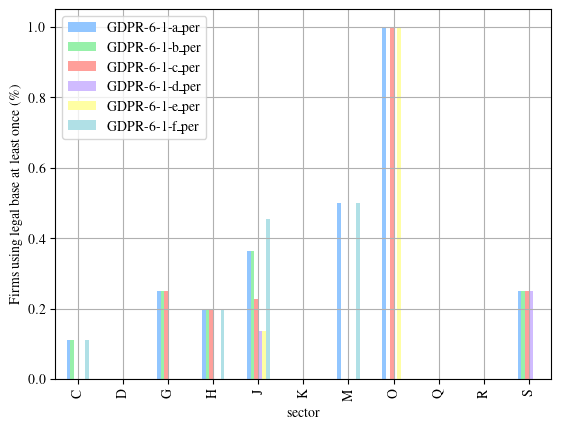

In [541]:
# plot
grouped.plot(x = 'sector', y = ['GDPR-6-1-a_per',
       'GDPR-6-1-b_per', 'GDPR-6-1-c_per', 'GDPR-6-1-d_per', 'GDPR-6-1-e_per',
       'GDPR-6-1-f_per'] , kind = 'bar')
plt.grid()
plt.ylabel("Firms using legal base at least once (\%)")
plt.show()
plt.savefig('legalBases_bySector')

<Figure size 640x480 with 0 Axes>

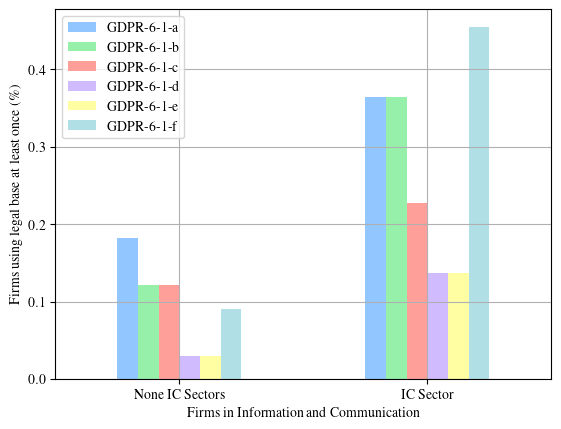

In [543]:
grouped_byJ.plot(x = 'in_J', y = ['GDPR-6-1-a_per',
       'GDPR-6-1-b_per', 'GDPR-6-1-c_per', 'GDPR-6-1-d_per', 'GDPR-6-1-e_per',
       'GDPR-6-1-f_per'], kind = 'bar')
plt.xlabel('Firms in Information and Communication')
plt.xticks(ticks = [0,1], labels = ['None IC Sectors', 'IC Sector'], rotation = 0)
plt.legend(labels= ['GDPR-6-1-a',
 'GDPR-6-1-b',
 'GDPR-6-1-c',
 'GDPR-6-1-d',
 'GDPR-6-1-e',
 'GDPR-6-1-f'])
plt.ylabel("Firms using legal base at least once (\%)")
plt.grid()
plt.show()
plt.savefig("legalBases_ITvsRest.png")